In [1]:
import pandas as pd
from google.colab import files
import io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Functions for loading data

def mount_drive():
  drive.mount("/content/drive")

def load_training_data(filename="reddit_train.csv"):
  uploaded = files.upload()
  return pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

def load_testing_data(filename="reddit_test.csv"):
  uploaded = files.upload()
  return pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

In [4]:
# Data Load and Pre-Processing (Credit: Cheng Siong)

train_data = load_training_data()
test_data = load_testing_data()

full_data = train_data.append(test_data)

y_train = full_data['REMOVED']

full_data.drop(labels='REMOVED', axis=1, inplace=True)

full_data['BODY'] = full_data['BODY'].fillna("").map(word_tokenize)
full_data['KEYWORDS'] = full_data['BODY'].map(FreqDist)

stop_words = stopwords.words("english")


def filterSentence(sentence):
    filteredSentence = []
    for w in sentence:
        if w not in stop_words:
            filteredSentence.append(w)
    return filteredSentence


full_data['KEYWORDS'] = full_data['BODY'].map(filterSentence)
full_data.drop('BODY', axis=1, inplace=True)

X = []

for elem in full_data['KEYWORDS']:
    X.append(' '.join(elem))

X = [str(item) for item in X]

vectorizer = TfidfVectorizer(encoding='latin1', ngram_range=(1, 3), min_df=0.001, max_df=0.25)

X_train = vectorizer.fit_transform(X)

Saving reddit_train.csv to reddit_train.csv


Saving reddit_test.csv to reddit_test (1).csv


In [5]:
# Normalization and Splitting Into Training & Testing Set

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

seed = 14
test_size = 0.30

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=test_size, random_state=seed)

In [10]:
# Grid-Search Cross Validation

param_set1 = {'n_estimators': range(20, 81, 10)}
cv1 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50, max_depth=8,
                                         max_features='sqrt', subsample=0.8, random_state=2),
    param_grid=param_set1, scoring="roc_auc", n_jobs=4, cv=5)
cv1.fit(X_train, y_train)
print(cv1.best_params_, cv1.best_score_) # Returned n_estimators=80 as optimal value in our tests

param_set2 = {'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)}
cv2 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_leaf=50, max_features='sqrt',
                                         subsample=0.8, random_state=2),
    param_grid=param_set2, scoring= "roc_auc", n_jobs=4, cv=5)
cv2.fit(X_train, y_train)
print(cv2.best_params_, cv2.best_score_) # Returned max_depth=15 and min_samples_split=600 as optimal values in our tests

param_set3 = {'max_features': range(7, 20, 2), 'min_samples_leaf': range(30, 71, 10)}
cv3 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_split=600, max_depth=15,
                                         subsample=0.8, random_state=2),
    param_grid=param_set3, scoring="roc_auc", n_jobs=4, cv=5)
cv3.fit(X_train, y_train)
print(cv3.best_params_, cv3.best_score_) # Returned max_features=19 and min_samples_leaf=30 as optimal values in our tests

param_set4 = {'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
cv4 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features=19, min_samples_leaf=30,
                                         max_depth=15, min_samples_split=600, random_state=2),
    param_grid=param_set4, scoring="roc_auc", n_jobs=4, cv=5)
cv4.fit(X_train, y_train)
print(cv4.best_params_, cv4.best_score_) # Returned subsample=0.9 as optimal value in our tests

param_set5 = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}
cv5 = GridSearchCV(
    estimator=GradientBoostingClassifier(n_estimators=80, max_features=19, min_samples_leaf=30, max_depth=15,
                                         min_samples_split=600, subsample=0.9, random_state=2),
    param_grid=param_set5, scoring="roc_auc", n_jobs=4, cv=5)
cv5.fit(X_train, y_train)
print(cv5.best_params_, cv5.best_score_) # Returned learning_rate=0.15 as optimal value in our tests

{'n_estimators': 80} 0.7561430425740391
{'max_depth': 15, 'min_samples_split': 600} 0.7646522173988946
{'max_features': 17, 'min_samples_leaf': 30} 0.7639240726542393
{'subsample': 0.9} 0.7638008797080033
{'learning_rate': 0.25} 0.7671380630346172


In [11]:
# Fitting and Evaluation Metrics

gb_clf = GradientBoostingClassifier(learning_rate=0.25, n_estimators=80, max_features=17, min_samples_leaf=30,
                                     max_depth=15, min_samples_split=600, subsample=0.9, random_state=2)
gb_clf.fit(X_train, y_train)
predictions = gb_clf.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[5257  541]
 [1796  941]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.91      0.82      5798
           1       0.63      0.34      0.45      2737

    accuracy                           0.73      8535
   macro avg       0.69      0.63      0.63      8535
weighted avg       0.71      0.73      0.70      8535



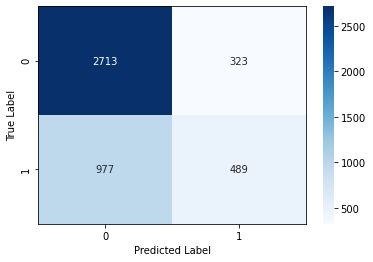

In [ ]:
# Heatmap of Confusion Matrix

cf_matrix = confusion_matrix(y_val, predictions)
heatmap = sns.heatmap(cf_matrix, annot=True, fmt='0.5g', cmap='Blues')
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()